# Import necessary libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import label_binarize
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import LeavePGroupsOut
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA

# Functions

In [2]:
def train_test_split_per_user(data, train_size=0.8, target_column='label_panas_negative_affect'):
    users = list(set(data.id))
    users = sorted(users, reverse=True)  # fix randomness
    total_users = len(users)
    slice_idx = int(train_size * total_users)
    users_train = users[:slice_idx]
    users_test = users[slice_idx:]
    
    # Split data based on user IDs
    train_data = data[data.id.isin(users_train)]
    test_data = data[data.id.isin(users_test)]
    
    x_train = train_data.drop(['id', target_column], axis=1) 
    y_train = train_data[target_column]  
    x_test = test_data.drop(['id', target_column], axis=1) 
    y_test = test_data[target_column]  
    
    return x_train, y_train, x_test, y_test

In [3]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

# Read the data

In [4]:
df = pd.read_pickle('../data/lifesnaps/lifesnapsv2.pkl')
df['id'] = df['id'].astype(str)
df = df[df['label_stai_stress'].notna()]
df = df.drop(columns=['label_panas_negative_affect', 'label_stress_sema'])
df

,id,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,...,bmi,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos,label_stai_stress
298,621e335a67b776a240bb12ff,35.560128,62.3900,34.057,96.0,15.0,72.0,0.733333,0.700,0.700000,...,1,-0.866025,0.000000,0.587785,-2.449294e-16,0.5,1.000000,0.809017,1.000000,0
301,621e34db67b776a240c9c2be,34.847500,62.3900,34.057,96.0,15.0,72.0,0.733333,0.700,0.700000,...,1,-0.866025,0.000000,0.587785,-2.449294e-16,0.5,1.000000,0.809017,1.000000,1
302,621e30e467b776a240e817c7,33.274919,52.5365,38.161,94.5,17.2,72.0,0.733333,0.700,0.700000,...,3,-0.866025,0.000000,0.587785,-2.449294e-16,0.5,1.000000,0.809017,1.000000,2
305,621e32af67b776a24045b4cf,33.926363,56.3910,41.789,96.7,13.4,72.0,0.733333,0.700,0.666667,...,1,-0.866025,0.000000,0.587785,-2.449294e-16,0.5,1.000000,0.809017,1.000000,2
310,621e2fce67b776a240279baa,34.379283,73.5040,21.036,98.0,15.2,72.0,0.733333,0.700,0.666667,...,1,-0.866025,0.000000,0.587785,-2.449294e-16,0.5,1.000000,0.809017,1.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4707,621e346f67b776a24081744f,33.933047,72.3240,26.077,96.0,18.8,72.0,0.733333,0.700,0.700000,...,3,0.866025,0.974928,0.587785,6.513725e-01,0.5,-0.222521,0.809017,-0.758758,1
4725,621e339967b776a240e502de,34.097435,51.6640,47.480,95.5,12.4,72.0,0.733333,0.725,0.700000,...,1,0.866025,0.974928,0.587785,6.513725e-01,0.5,-0.222521,0.809017,-0.758758,1
4870,621e2f9167b776a240011ccb,34.359505,59.2550,26.811,95.4,15.4,72.0,0.700000,0.700,0.766667,...,1,0.866025,-0.781831,0.587785,-1.011683e-01,0.5,0.623490,0.809017,-0.994869,2
4899,621e367e67b776a24087d75d,33.189233,54.6510,40.814,96.0,11.6,72.0,0.733333,0.700,0.700000,...,3,0.866025,0.000000,0.809017,-2.993631e-01,0.5,1.000000,0.587785,-0.954139,0


In [5]:
df['label_stai_stress'].value_counts()

label_stai_stress
0    102
1     88
2     77
Name: count, dtype: int64

In [6]:
features = ['nightly_temperature', 'nremhr', 'rmssd', 'spo2', 'full_sleep_breathing_rate', 'stress_score', 'sleep_points_percentage', 'exertion_points_percentage', 'responsiveness_points_percentage', 'daily_temperature_variation', 'calories', 'filteredDemographicVO2Max', 'distance', 'bpm', 'lightly_active_minutes','moderately_active_minutes', 'very_active_minutes', 'sedentary_minutes', 'scl_avg', 'resting_hr', 'sleep_duration', 'minutesAsleep', 'minutesAwake', 'sleep_efficiency', 'sleep_deep_ratio', 'sleep_wake_ratio', 'sleep_light_ratio', 'sleep_rem_ratio', 'steps', 'minutes_in_default_zone_1', 'minutes_below_default_zone_1', 'month_sin', 'weekday_sin', 'week_sin', 'day_sin', 'month_cos', 'weekday_cos', 'week_cos', 'day_cos']

scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Generic Model
each user belongs to either the train or the test set

In [7]:
X_train, y_train, X_test, y_test = train_test_split_per_user(df,target_column='label_stai_stress')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

(199, 42) (199,) (68, 42) (68,)


Dummy f1 score: 0.6029411764705882


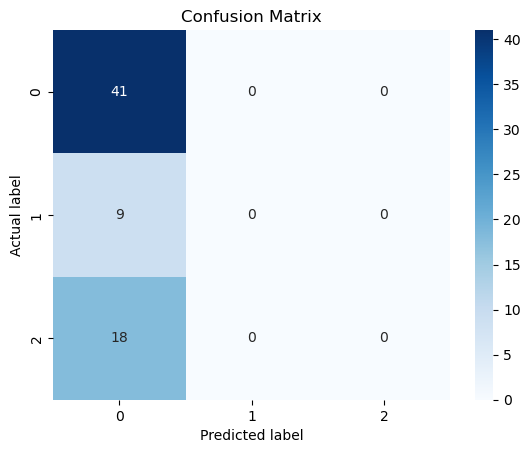

In [8]:
# Dummy Classifier for comparison
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_smote, y_train_smote)
dummy_predictions = dummy_clf.predict(X_test)

f1 = f1_score(y_test, dummy_predictions, average='micro')
print(f'Dummy f1 score: {f1}')
plot_confusion_matrix(y_test, dummy_predictions)

In [9]:
#clf = SVC(probability=True)
#clf = RandomForestClassifier(n_estimators=100, random_state=42)
#clf = XGBClassifier(n_estimators=100, random_state=42)
#clf = GradientBoostingClassifier(n_estimators=160, learning_rate=0.3, random_state=42)
#clf = LogisticRegression(max_iter=200, random_state=42)
clf = LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None, priors=None, shrinkage=None, solver='svd', store_covariance=False, tol=0.0001)
#clf = LGBMClassifier(boosting_type='gbdt', n_estimators=100)

In [10]:
clf.fit(X_train_smote, y_train_smote)
y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='micro')
print(f"F1 Score: {f1}")
print(confusion_matrix(y_test, y_pred))

F1 Score: 0.5
[[26  8  7]
 [ 6  1  2]
 [ 7  4  7]]


In [11]:
y_pred_df = pd.DataFrame(y_pred, columns=['label_stai_stress'])

y_test.to_csv('../data/lifesnaps/predictions/stai_y_test_generic.csv', index=False)
y_pred_df.to_csv('../data/lifesnaps/predictions/stai_pred_generic.csv', index=False)
X_test.to_csv('../data/lifesnaps/predictions/stai_X_test_generic.csv', index=False)

In [12]:
y_prob = clf.predict_proba(X_test)  # matrix of probabilities
# Binarize the output labels for multi-class ROC AUC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotting
plt.figure(figsize=(10, 8))
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()

NameError: name 'cycle' is not defined

<Figure size 1000x800 with 0 Axes>

# Leave one person out (LOPO) method

In [13]:
X = df.drop(['label_stai_stress', 'id'], axis=1)  # Features
y = df['label_stai_stress']  # Target variable
unique_labels = y.unique()
groups = df['id']  # Group identifier for LOPO

model = DummyClassifier(strategy='most_frequent')
#model = SVC()
#model = RandomForestClassifier(n_estimators=100, random_state=42)
#model = XGBClassifier(n_estimators=100, random_state=42)
#model = GradientBoostingClassifier(n_estimators=160, learning_rate=0.3, random_state=42)
#model = LogisticRegression(random_state=42)
#model = LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None, priors=None, shrinkage=None, solver='svd', store_covariance=False, tol=0.0001)
#model = LGBMClassifier(boosting_type='gbdt', n_estimators=100)

cv = LeavePGroupsOut(n_groups=1)
scores = []
confusion_matrices = []


for train_idx, test_idx in cv.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='micro')
    scores.append(score)
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    confusion_matrices.append(cm)

# Calculate the average performance across all LOPO iterations
average_score = np.mean(scores)
print(f'Average f1-scores across all LOPO iterations: {average_score}')
total_confusion_matrix = np.sum(confusion_matrices, axis=0)
print(total_confusion_matrix)

Average f1-scores across all LOPO iterations: 0.3592392932015574
[[102   0   0]
 [ 88   0   0]
 [ 77   0   0]]


In [14]:
X = df.drop(['label_stai_stress', 'id'], axis=1)  # Features
y = df['label_stai_stress']  # Target variable
unique_labels = y.unique()
groups = df['id']  # Group identifier for LOPO

model = LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None, priors=None, shrinkage=None, solver='svd', store_covariance=False, tol=0.0001)

cv = LeavePGroupsOut(n_groups=1)
scores = []
confusion_matrices = []
all_y_pred = []
all_y_test = []
all_X_test = []

for train_idx, test_idx in cv.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='micro')
    scores.append(score)
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    confusion_matrices.append(cm)

    # Append the current iteration's data to the lists
    all_y_pred.extend(y_pred.tolist())
    all_y_test.extend(y_test.tolist())
    all_X_test.append(X_test)

# Calculate the average performance across all LOPO iterations
average_score = np.mean(scores)
print(f'Average f1-scores across all LOPO iterations: {average_score}')
total_confusion_matrix = np.sum(confusion_matrices, axis=0)
print(total_confusion_matrix)

# Convert lists and DataFrame pieces to full DataFrames
all_y_pred_df = pd.DataFrame(all_y_pred, columns=['label_stai_stress'])
all_y_test_df = pd.DataFrame(all_y_test, columns=['label_stai_stress'])
all_X_test_df = pd.concat(all_X_test).reset_index(drop=True)

# Saving the DataFrames to CSV files
all_y_test_df.to_csv('../data/lifesnaps/predictions/stai_y_test_LOPO.csv', index=False)
all_y_pred_df.to_csv('../data/lifesnaps/predictions/stai_y_pred_LOPO.csv', index=False)
all_X_test_df.to_csv('../data/lifesnaps/predictions/stai_X_test_LOPO.csv', index=False)

Average f1-scores across all LOPO iterations: 0.48087002096436066
[[53 38 11]
 [38 32 18]
 [21 18 38]]


# Deep learning

In [15]:
X_train, y_train, X_test, y_test = train_test_split_per_user(df,target_column='label_stai_stress')

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

mlp = MLPClassifier(random_state=42, max_iter=800)
mlp.fit(X_train_smote, y_train_smote)

y_pred = mlp.predict(X_test)
y_pred_proba = mlp.predict_proba(X_test)[:, 1]  # Get probability for the positive class

# F1 Score
f1 = f1_score(y_test, y_pred, average='micro')
print(f'F1 Score: {f1}')

y_prob = clf.predict_proba(X_test)  # matrix of probabilities
# Binarize the output labels for multi-class ROC AUC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotting
plt.figure(figsize=(10, 8))
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

F1 Score: 0.4264705882352941


NameError: name 'cycle' is not defined

<Figure size 1000x800 with 0 Axes>